In [2]:
import json
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os

import numpy as np

from sky_spot import utils

sns.set_style('whitegrid')


/tmp/ipykernel_1732/1065054098.py:8: RuntimeWarning: divide by zero encountered in divide
  p = spot_price * avg_spot_time / (avg_spot_time - d)
/tmp/ipykernel_1732/1065054098.py:8: RuntimeWarning: divide by zero encountered in divide
  p = spot_price * avg_spot_time / (avg_spot_time - d)
/tmp/ipykernel_1732/1065054098.py:8: RuntimeWarning: divide by zero encountered in divide
  p = spot_price * avg_spot_time / (avg_spot_time - d)
/tmp/ipykernel_1732/1065054098.py:8: RuntimeWarning: divide by zero encountered in divide
  p = spot_price * avg_spot_time / (avg_spot_time - d)
/tmp/ipykernel_1732/1065054098.py:8: RuntimeWarning: divide by zero encountered in divide
  p = spot_price * avg_spot_time / (avg_spot_time - d)
/tmp/ipykernel_1732/1065054098.py:8: RuntimeWarning: divide by zero encountered in divide
  p = spot_price * avg_spot_time / (avg_spot_time - d)
/tmp/ipykernel_1732/1065054098.py:8: RuntimeWarning: divide by zero encountered in divide
  p = spot_price * avg_spot_time / (avg_

Text(0.5, 1.0, 'Effective price of spot instances for different overheads')

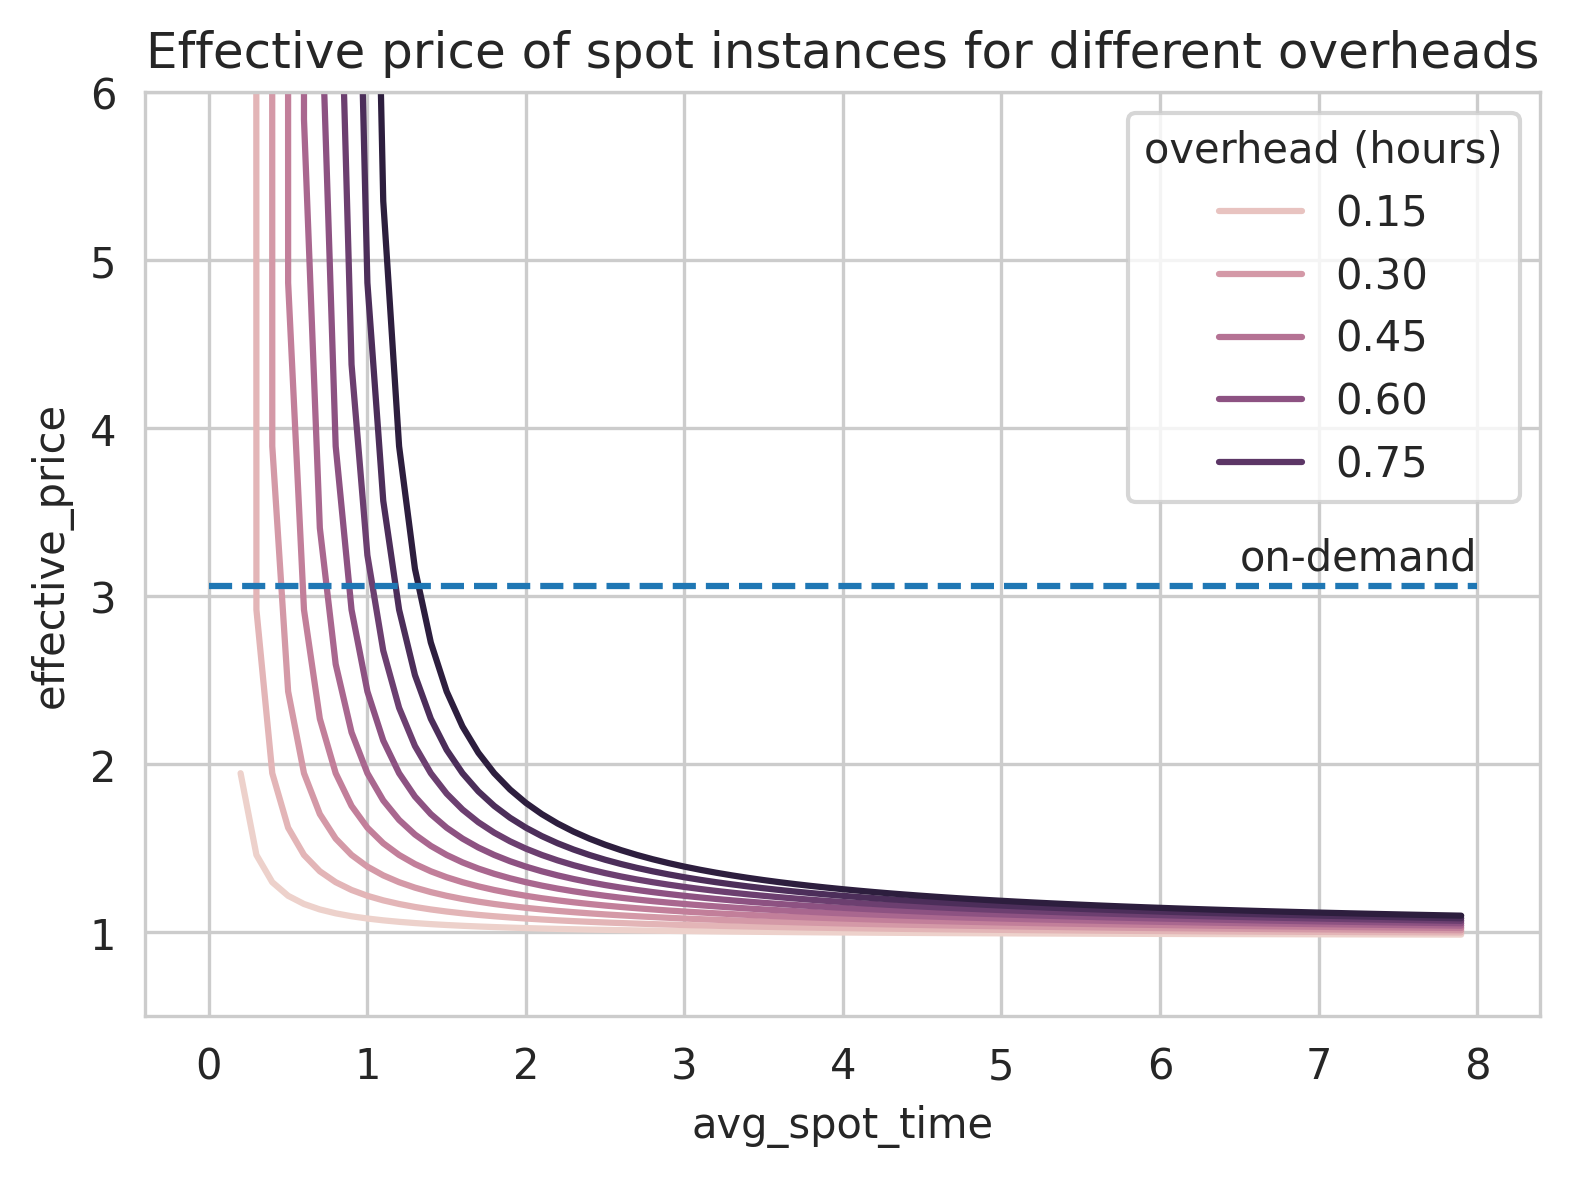

In [3]:
avg_spot_time = np.arange(0.1, 8, 0.1)
overhead = np.arange(0.1, 1.0, 0.1)


def effective_price(avg_spot_time, d):
    spot_price = utils.COSTS[utils.ClusterType.SPOT]

    p = spot_price * avg_spot_time / (avg_spot_time - d)
    return np.where(p < 0, 1000, p)

fig = plt.figure(dpi=300, figsize=(6, 4))
ax = fig.add_subplot(111)

df = pd.DataFrame(columns=['avg_spot_time', 'overhead', 'effective_price'])
for d in overhead:
    effective_prices = effective_price(avg_spot_time, d)
    df = pd.concat([df, pd.DataFrame({
        'avg_spot_time': avg_spot_time,
        'overhead (hours)': d,
        'effective_price': effective_prices
    })], ignore_index=True)

sns.lineplot(x='avg_spot_time', y='effective_price', hue='overhead (hours)', data=df, ax=ax)
ax.hlines(utils.COSTS[utils.ClusterType.ON_DEMAND], 0, 8, linestyles='dashed', label='on-demand')
# ax.text(8, utils.COSTS[utils.ClusterType.ON_DEMAND], 'on-demand', transform=ax.transAxes)
ax.annotate('on-demand', xy=(8, utils.COSTS[utils.ClusterType.ON_DEMAND]), xytext=(8-1.5, utils.COSTS[utils.ClusterType.ON_DEMAND] + 0.1))
ax.set_ylim(0.5, 6)
ax.set_title('Effective price of spot instances for different overheads')

In [6]:
from sky_spot import traces

# DATE = '2023-02-15'
ORIGINAL_TRACE_PATH = '../../data/real/ping_based'
# ORIGINAL_TRACE_PATH = f'../../data/real/availability/{DATE}/parsed'

# EXP_PATH = f'../../exp/real/{DATE}'
EXP_PATH = f'../../exp/real'

for file in os.listdir(ORIGINAL_TRACE_PATH):
    print(file)
    if file.endswith('.json'):
        filename = file.split('.')[0]
        output_dir = f'{EXP_PATH}/effective_price/{filename}.json/traces/random_start'
        os.makedirs(output_dir, exist_ok=True)
        traces.random_start.generate_random_traces(
            os.path.join(ORIGINAL_TRACE_PATH, file),
            num_traces=300,
            output_dir=output_dir
        )


us-west-2a_v100_1.json
random_start_time_100
us-west-2a_k80_1.json
us-west-2b_v100_1.json
random_start_time
us-west-2b_v100_8.json
us-west-2a_v100_8.json
us-west-2b_k80_8.json
us-west-2a_k80_8.json
us-west-2b_k80_1.json
parse.py


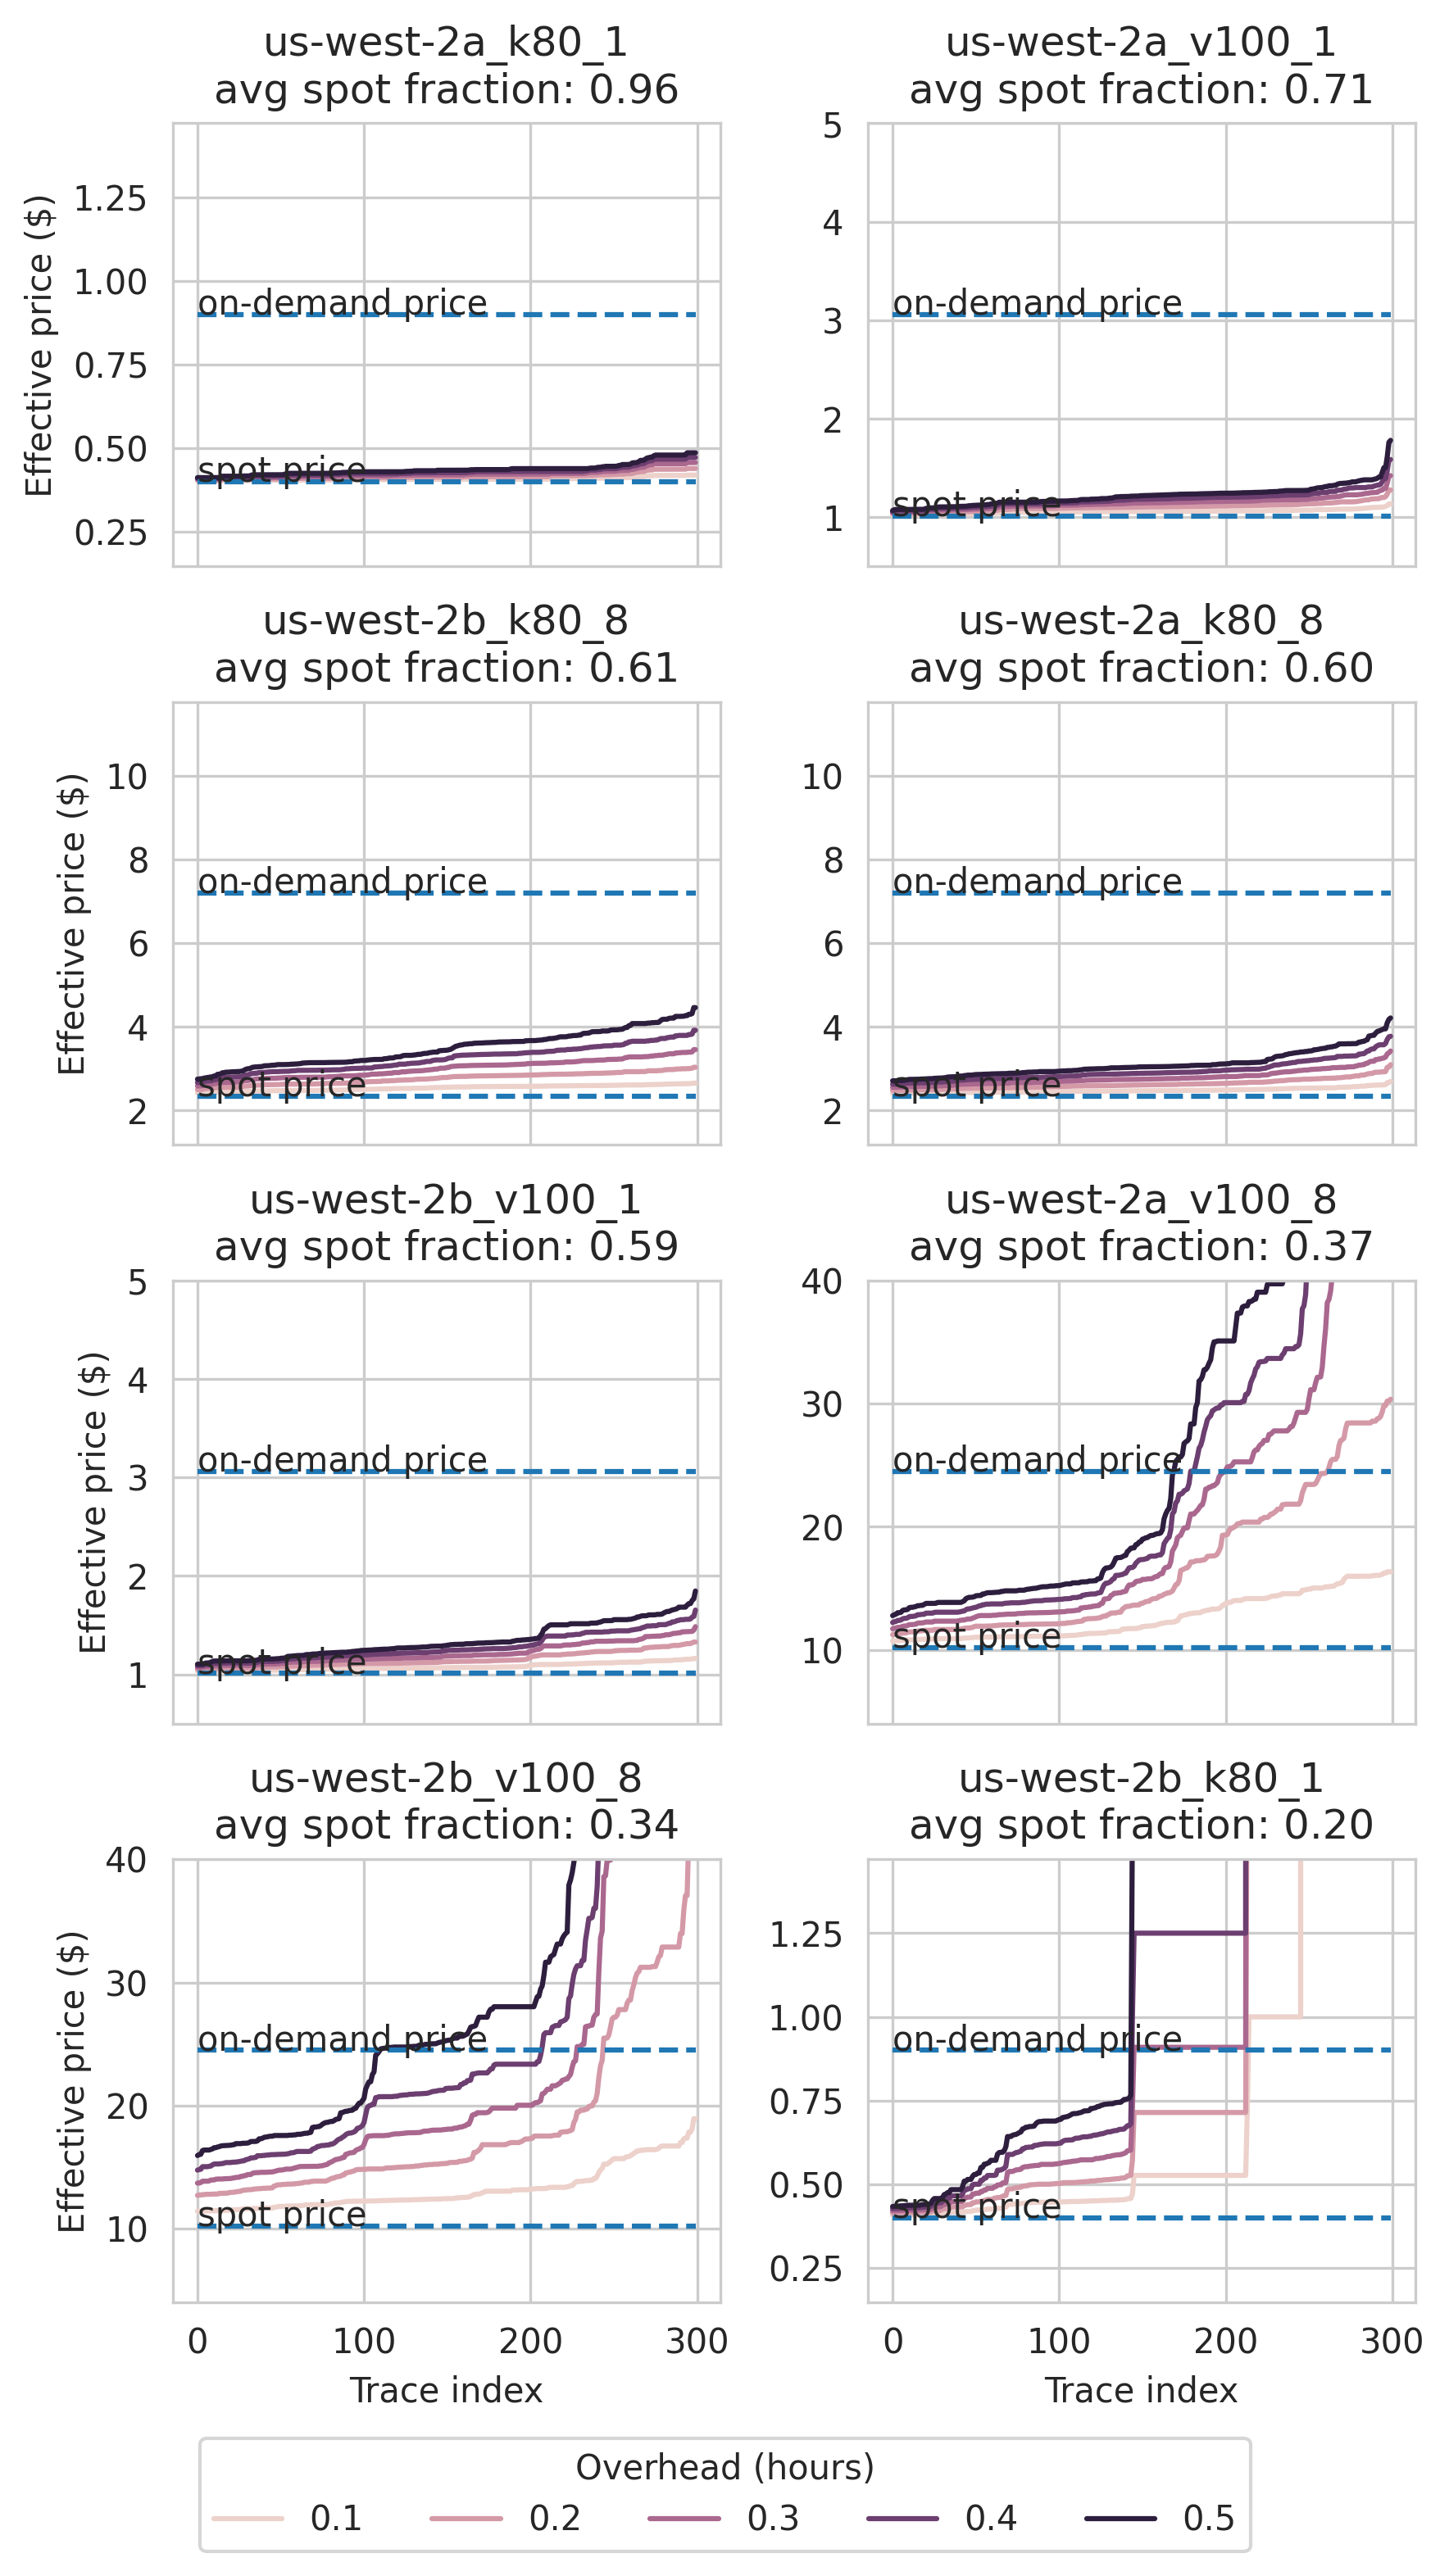

In [8]:
TRACE_PATH = f'{EXP_PATH}/effective_price'

overhead = [0.1, 0.2, 0.3, 0.4, 0.5]
spot_price = utils.COSTS[utils.ClusterType.SPOT]
v100_base_cost = utils.COSTS[utils.ClusterType.ON_DEMAND]

cost_scales = {
    'v100_1': (3.06 / v100_base_cost, 1.01/ spot_price),
    'v100_8': (24.48 / v100_base_cost, 10.19 / spot_price),
    'k80_1': (0.9 / v100_base_cost, 0.4 / spot_price),
    'k80_8': (7.200 / v100_base_cost, 2.34 / spot_price),
}



dfs = []
for folder in os.listdir(TRACE_PATH):
    if '.json' not in folder:
        continue
    df = pd.DataFrame(columns=['trace_ind', 'overhead (hours)', 'effective_price', 'spot_fraction'])
    for root, dirs, files in os.walk(os.path.join(TRACE_PATH, folder, 'traces')):
        for cost_scale in cost_scales:
            if cost_scale in root:
                spot_price = utils.COSTS[utils.ClusterType.SPOT] * cost_scales[cost_scale][1]
                on_demand_price = utils.COSTS[utils.ClusterType.ON_DEMAND] * cost_scales[cost_scale][0]
                break

        for file in files:
            if not file.endswith('.json'):
                continue
            with open(os.path.join(root, file)) as f:
                trace = json.load(f)
            gap_seconds = trace['metadata']['gap_seconds']
            availability_trace = 1 - np.array(trace['data'])

            # Get continuguous 1s within the trace.
            expanded = np.array([0] + availability_trace.tolist() + [0])
            diff = np.diff(expanded)
            start = np.where(diff == 1)[0]
            end = np.where(diff == -1)[0]
            lengths = (end - start) * gap_seconds / 3600

            trace_ind = int(os.path.basename(file).rpartition('.json')[0])
            for d in overhead:
                effective_runtime = lengths - d
                effective_runtime = np.where(effective_runtime < 0, 0, effective_runtime)
                if sum(effective_runtime) == 0:
                    trace_effective_price = 1000
                else:
                    trace_effective_price = spot_price * sum(lengths) / sum(effective_runtime)
                new_df = pd.DataFrame([{
                    'trace_ind': trace_ind,
                    'overhead (hours)': d,
                    'effective_price': trace_effective_price,
                    'spot_fraction': sum(lengths) / 52
                }])
                if len(df) > 0:
                    df = pd.concat([df, new_df], ignore_index=True)
                else:
                    df = new_df
    avg_spot_fraction = df['spot_fraction'].mean()
    df.drop(columns=['spot_fraction'], inplace=True)
    dfs.append([folder, avg_spot_fraction, spot_price, on_demand_price, df])

dfs = sorted(dfs, key=lambda x: x[1], reverse=True)
env_paths = [x[0] for x in dfs]
# env_paths = ['us-west-2a_k80_1', 'us-west-2a_v100_1', 'us-west-2b_v100_1', 'us-west-2b_k80_1']
fig = plt.figure(dpi=300, figsize=(6, 10))
axes = fig.subplots((len(env_paths) + 1) // 2, 2, sharex=True)
cnt = 0
for i, (folder, avg_spot_fraction, spot_price, on_demand_price, df) in enumerate(dfs):
    for env_path in env_paths:
        if env_path in folder:
            break
    else:
        continue

    ax = axes[cnt // 2, cnt % 2]
    cnt += 1
    df = df.sort_values(['effective_price']).groupby(['overhead (hours)']).apply(lambda x: x.reset_index(drop=True))
    sns.lineplot(x=df.index.get_level_values(1),
                y=df['effective_price'],
                hue=df['overhead (hours)'],
                ax=ax)
    ax.hlines(on_demand_price,
            0,
            max(df['trace_ind']),
            linestyles='dashed')
    ax.annotate('on-demand price',
                xy=(min(df['trace_ind']), on_demand_price),
                xytext=(min(df['trace_ind']), on_demand_price))
    ax.hlines(spot_price, 0, max(df['trace_ind']), linestyles='dashed')
    ax.annotate('spot price',
                xy=(min(df['trace_ind']), spot_price),
                xytext=(min(df['trace_ind']),
                        spot_price))
    ax.set_title(f'{folder.replace(".json", "")}\navg spot fraction: {avg_spot_fraction:.2f}')
    ax.legend().set_visible(False)
    ax.set_ylim(0.5 * on_demand_price / v100_base_cost,
                5 * on_demand_price / v100_base_cost)
    ax.set_ylabel('')


for ax in axes[-1, :]:
    ax.set_xlabel('Trace index')
for ax in axes[:, 0]:
    ax.set_ylabel('Effective price ($)')

handler_ax = axes[0, 0]
leg = handler_ax.get_legend()
for t in leg.texts:
    # truncate label text to 4 characters
    t.set_text(f'{float(t.get_text()):.2f}')
fig.legend(title='Overhead (hours)',
           loc='lower center',
           ncol=8,
           handles=handler_ax.get_legend_handles_labels()[0],
           bbox_to_anchor=(0.5, -0.05))

fig.tight_layout()
fig.savefig('effective_price.jpg', bbox_inches='tight')